In [448]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
#tf.config.optimizer.set_jit(False)
from tensorflow import keras
from keras.models import load_model
import random
from sklearn.metrics import mean_absolute_error
#import matplotlib
import os
import pickle

from keras.constraints import Constraint
from keras.layers import Layer
from keras import backend as K

import jax
import jax.nn as nn
from jax.random import normal
from jax.experimental import sparse
#from sparse import bcoo_concatenate
from jax.tree_util import tree_map
import jaxlib
import jax.numpy as jnp
import haiku as hk
import optax
from jax import jit
from functools import partial
import functools
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix
from optax import GradientTransformation

from utils import constrained_gradients, StateProbBound, StateProbFolded, Between, between
from linear import custom_linear
from training import model_training, shuffle_weights

In [235]:
%load_ext autoreload
%autoreload 2

# Define arguments

In [363]:
data_train = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'
data_valid = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt' 
data_obs = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt' 
o = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/ '
e = 100 
l1_regularization_factor = 0 
l2_regularization_factor = 0 
p = 1000 
num_samples= 128,256,512,1024 
learning_rate= 0.001 
num_resamplings= 10 
num_models= 1 
random_seed= 1


In [364]:
args = {
    "data_train": "'/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'",
    "data_valid": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt",
    "data_obs": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt",
    "output_directory": "/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/",
    "number_additive_traits": 1,
    "l1_regularization_factor": "0.0001,0.001,0.01,0.1",
    "l2_regularization_factor": "0.0001,0.001,0.01,0.1",
    "num_epochs_grid": 10,
    "num_epochs": 10,
    "num_samples": "128,256,512,1024",
    "learning_rate": "0.0001,0.001,0.01,0.1",
    "num_resamplings": 10,
    "early_stopping": False,
    "num_models": 2,
    "random_seed": 1
}

data_train_file = args["data_train"]
data_valid_file = args["data_valid"]
data_obs_file = args["data_obs"]
output_directory = args["output_directory"]
number_additive_traits = args["number_additive_traits"]
num_epochs_grid = args["num_epochs_grid"]
num_epochs = args["num_epochs"]
num_resamplings = args["num_resamplings"]
early_stopping = args["early_stopping"]
num_models = args["num_models"]
random_seed = args["random_seed"]

#Grid search arguments
l1 = [float(i) for i in args["l1_regularization_factor"].split(",")]
l2 = [float(i) for i in args["l2_regularization_factor"].split(",")]
batch_size = [int(i) for i in args["num_samples"].split(",")]
learn_rate = [float(i) for i in args["learning_rate"].split(",")]

In [480]:
output_directory

'/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/'

# Load model data jax

In [459]:
data_train_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_train.txt'

data_valid_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_valid.txt' 

data_obs_file = '/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p//dataset_all.txt'

In [462]:
#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)

#Load model data
model_data_jax = load_model_data_jax({
    "train": data_train_file,
    "valid": data_valid_file,
    "obs": data_obs_file
    })

In [471]:
model_data_jax['valid']

{'select': DeviceArray([[1., 0.],
              [1., 0.],
              [0., 1.],
              ...,
              [0., 1.],
              [1., 0.],
              [1., 0.]], dtype=float32),
 'fold': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'bind': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'target': DeviceArray([-0.41231823, -0.77879196, -0.3400993 , ..., -0.45269558,
              -1.261652  , -0.30744419], dtype=float32),
 'target_sd': DeviceArray([0.08256807, 0.252

In [461]:
from utils import constrained_gradients, StateProbBound, StateProbFolded, Between, between, get_seq_id, get_layer_index
from training import model_training, shuffle_weights, fit_model_grid_jax
from dataloading import load_model_data_jax, resample_training_data_jax

# Resample training data jax

In [370]:
#Resample training data
num_resamplings = 1

#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)

if num_resamplings!=0:
    model_data_jax["train"] = resample_training_data_jax(
        tensor_dict = model_data_jax["train"],
        n_resamplings = num_resamplings,
        rng = rng)

here


In [463]:
model_data_jax["train"]

{'select': DeviceArray([[0., 1.],
              [0., 1.],
              [1., 0.],
              ...,
              [1., 0.],
              [1., 0.],
              [0., 1.]], dtype=float32),
 'fold': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'bind': DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              ...,
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.],
              [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'target': DeviceArray([-0.33598602, -0.8518485 , -1.0957463 , ..., -0.26487023,
              -1.166961  , -0.66433465], dtype=float32),
 'target_sd': DeviceArray([0.11158013, 0.172

# Create model Jax

In [473]:
from training import fit_model_grid_jax

In [474]:
#Fit model
if len(l1) == 1 and len(l2) == 1 and len(batch_size) == 1 and len(learn_rate) == 1:
    best_params = {
        "num_samples": batch_size[0],
        "learning_rate": learn_rate[0],
        "l1_regularization_factor": l1[0],
        "l2_regularization_factor": l2[0],
        "number_additive_traits": 1
    }
else:
    parameter_grid = [{
        "num_samples": i,
        "learning_rate": j,
        "l1_regularization_factor": k,
        "l2_regularization_factor": l,
        "number_additive_traits": 1
    } for i in batch_size for j in learn_rate for k in l1 for l in l2]

    rng = jax.random.PRNGKey(random_seed)
    rngs = jax.random.split(rng, len(parameter_grid[:3]))
    #print(len(parameter_grid))
    grid_results = [fit_model_grid_jax(params, model_data_jax, num_epochs_grid, rng_key) for params, rng_key in zip(parameter_grid, rngs)]

    best_params = parameter_grid[np.argmin(grid_results)]

    print("Best: %f using %s" % (min(grid_results), best_params))

num_samples = best_params['num_samples']
learning_rate = best_params['learning_rate']
l1_regularization_factor = best_params['l1_regularization_factor']
l2_regularization_factor = best_params['l2_regularization_factor']


Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.0001, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.001, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
Best: 0.427219 using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}


# Fitting final model and testing

In [484]:
#Output model directory
model_directory = os.path.join(output_directory, "whole_model")
#Create output model directory
try:
  os.mkdir(model_directory)
except FileExistsError:
  print("Warning: Output model directory already exists.")

#Output plot directory
plot_directory = os.path.join(output_directory, "plots")
#Create output plot directory
try:
  os.mkdir(plot_directory)
except FileExistsError:
  print("Warning: Output plot directory already exists.")

#Weights directory
weights_directory = os.path.join(output_directory, "weights")
#Create output plot directory
try:
  os.mkdir(weights_directory)
except FileExistsError:
  print("Warning: Output weights directory already exists.")

In [481]:
plot_directory

'/Users/pierredemetz/UCL_work/Crick/doubledeepms/Results//Data/mochi/GRB2-SH3/mochi__fit_tmodel_3state_sparse_dimsum128_subsample100p/plots'

In [477]:
from training import model_training, shuffle_weights

Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
[0.6976140141487122, 0.6637396812438965, 0.6319745779037476, 0.602327823638916, 0.5750360488891602, 0.5503971576690674, 0.5282517671585083, 0.5083247423171997, 0.48985135555267334, 0.47273972630500793]


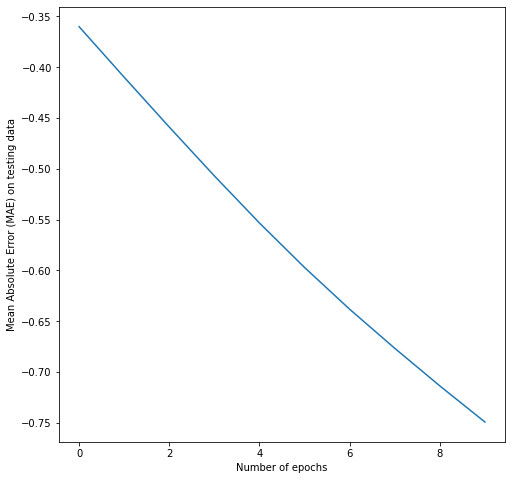

Grid search using {'num_samples': 128, 'learning_rate': 0.0001, 'l1_regularization_factor': 0.0001, 'l2_regularization_factor': 0.01, 'number_additive_traits': 1}


/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:143: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/pierredemetz/miniconda3/envs/pierre/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
epoch done
[0.6976140141487122, 0.6637396812438965, 0.6319745779037476, 0.602327823638916, 0.5750360488891602, 0.5503971576690674, 0.5282517671585083, 0.5083247423171997, 0.48985135555267334, 0.47273972630500793]


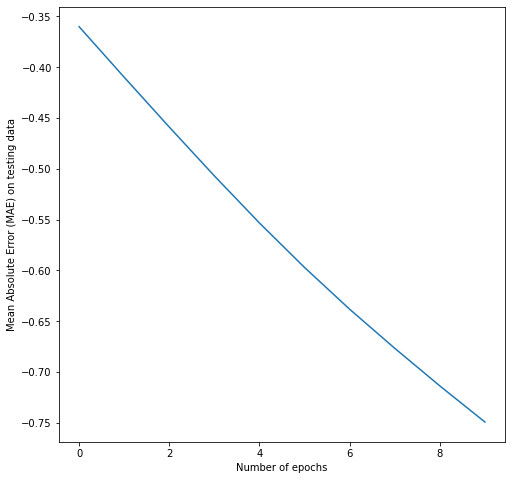

In [485]:
num_samples = best_params['num_samples']
learning_rate = best_params['learning_rate']
l1_regularization_factor = best_params['l1_regularization_factor']
l2_regularization_factor = best_params['l2_regularization_factor']
number_additive_traits = best_params['number_additive_traits']

#######################################################################
## BUILD FINAL NEURAL NETWORK ##
#######################################################################

#create the rng
random_seed = 42
rng = jax.random.PRNGKey(random_seed)
num_models = 2 

model, optimizer = create_model_jax(
    rng=rng,
    learn_rate=learning_rate,
    l1=l1_regularization_factor,
    l2=l2_regularization_factor,
    input_dim_select=model_data_jax['train']['select'].shape[1],
    input_dim_folding=model_data_jax['train']['fold'].shape[1],
    input_dim_binding=model_data_jax['train']['bind'].shape[1],
    number_additive_traits=number_additive_traits
)

weights = model.init(rng, model_data_jax['train']['select'], model_data_jax['train']['fold'], model_data_jax['train']['bind'])
opt_state = optimizer.init(weights)

for model_count in range(num_models):

    #Shuffle model weights
    shuffled_weights = shuffle_weights(rng, weights)

    #Fit the model on best params
    history, model, trained_weights = model_training(model, optimizer, shuffled_weights, opt_state, best_params, model_data_jax, num_epochs_grid, rng)
        
    # Model predictions on observed variants
    model_predictions = model.apply(trained_weights, 
                                    model_data_jax['obs']['select'],
                                    model_data_jax['obs']['fold'],
                                    model_data_jax['obs']['bind']
                                   )
    #save model
    #model.save(os.path.join(model_directory, 'my_model_'+str(model_count)))
    with open(os.path.join(weights_directory, f'weights_{model_count}.pickle'), 'wb') as handle:
        pickle.dump(shuffled_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    #load model
    #model = load_model(os.path.join(model_directory, 'my_model_'+str(model_count)))
    with open(os.path.join(weights_directory, f'weights_{model_count}.pickle'), 'rb') as handle:
        shuffled_weights_reloaded = pickle.load(handle)
        
    print(history)
    #Plot model performance per epoch
    my_figure = plt.figure(figsize = (8,8))
    plt.plot(np.log(history))
    plt.xlabel('Number of epochs')
    plt.ylabel('Mean Absolute Error (MAE) on testing data')
    plt.show()
    my_figure.savefig(os.path.join(plot_directory, "model_performance_perepoch_"+str(model_count)+".pdf"), bbox_inches='tight')
    

# Finish the plots below and then move everything to .py folder

In [486]:
# Function to get intermediate output from the model
def get_intermediate_output(params, rng, inputs, module_name):
    model = hk.transform_with_state(lambda x: hk.apply_module(params, rng, module_name, x))
    return model.apply(params, rng, inputs)

# Calculate folding and binding additive traits
folding_additive_trait_df = pd.DataFrame(get_intermediate_output(params, rng, [model_data_jax['obs']['select'],
                                                                              model_data_jax['obs']['fold'],
                                                                              model_data_jax['obs']['bind']],
                                                                  "folding_additivetrait"))

binding_additive_trait_df = pd.DataFrame(get_intermediate_output(params, rng, [model_data_jax['obs']['select'],
                                                                              model_data_jax['obs']['fold'],
                                                                              model_data_jax['obs']['bind']],
                                                                  "binding_additivetrait"))


#Results data frame
dataframe_to_export = pd.DataFrame({
    "seq" : np.array(model_data['obs']['sequence']).flatten(),
    "observed_fitness" : np.array(model_data['obs']['target']).flatten(),
    "predicted_fitness" : model_predictions.flatten(),
    "additive_trait_folding" : folding_additive_trait_df["trait 0"],
    "additive_trait_binding" : binding_additive_trait_df["trait 0"],
    "training_set" : np.array(model_data['obs']['training_set']).flatten()
})
#Save as csv file
dataframe_to_export.to_csv(os.path.join(output_directory, "predicted_fitness_"+str(model_count)+".txt"),
                           sep = "\t",
                           index = False)


# Save model weights
dataframe_to_export_folding = pd.DataFrame({
    "id" : model_data_jax['obs']['fold_colnames'],
    "folding_coefficient" : [params["folding_additive"]["w"] for _ in range(len(model_data_jax['obs']['fold_colnames']))]})
dataframe_to_export_binding = pd.DataFrame({
    "id" : model_data_jax['obs']['bind_colnames'],
    "binding_coefficient" : [params["binding_additive"]["w"] for _ in range(len(model_data_jax['obs']['bind_colnames']))]})

# Save dataframes as csv files 
#Merge
dataframe_to_export = dataframe_to_export_folding.merge(dataframe_to_export_binding, left_on='id', right_on='id', how='outer')
#Save as csv file
dataframe_to_export.to_csv(os.path.join(output_directory, "model_weights_"+str(model_count)+".txt"),
                           sep = "\t",
                           index = False)

# Save remaining model parameters (linear layers)
with open(os.path.join(output_directory, "model_parameters_"+str(model_count)+".txt"), 'w') as f:
    for module_name, module_params in params.items():
        if module_name in ["folding_additive", "binding_additive"]:
            f.write(module_name.replace("additive", "linear")+"_kernel\n")
            f.write(str(float(module_params["w"]))+"\n")
            f.write(module_name.replace("additive", "linear")+"_bias\n")
            f.write(str(float(module_params["b"]))+"\n")

TypeError: state argument does not appear valid. It should be a mapping but is of type <class 'jaxlib.xla_extension.DeviceArray'>. For reference the parameters for apply are `apply(params, rng, ...)`` for `hk.transform` and `apply(params, state, rng, ...)` for `hk.transform_with_state`.
The argument was: DeviceArray([ 0, 42], dtype=uint32).